Accelerating computations with field-line mapping
=================================================

This examples highlights some ways to accelerate your calculations with field line mapping. We will use a W7-X case.

In [1]:
import fusionsc as fsc
from fusionsc.devices import w7x
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fsc.resolve.importOfflineData("../../w7x-op21.fsc")

In [3]:
grid = w7x.defaultGrid()
grid.nPhi = 32
print(grid)

rMin: 4
rMax: 7
zMin: -1.5
zMax: 1.5
nSym: 5
nR: 128
nZ: 128
nPhi: 32


Note: There are two functions to perform axis-current computations, the `fsc.flt.axisCurrent` and the `fsc.devices.w7x.axisCurrent` function. They take exactly the same arguments, but `fsc.flt.axisCurrent` has default behavior tailored towards generic devices, while `fsc.devices.w7x.axisCurrent` has default parameters more suited for Wendelstein 7-X calculations (current direction, default grid, starting points).

In [ ]:
field = w7x.standard()
#field = field + w7x.axisCurrent(field, 2000, grid = grid)

# Note: The above is equivalent to
# field = field + fsc.flt.axisCurrent(field, 10000, grid = w7x.defaultGrid, direction = "cw", startingPoint = [6, 0, 0])

field = field.compute(grid)

Preparing the mapping
---------------------

To prepare the mapping, we need to (in principle) specify the planes in which we want the remapping to occur. For W7-X, a function with recommended defaults is provided in the w7x device-specific module (same arguments, but different default values).

In [5]:
mapping = w7x.computeMapping(field)

# Note: The above is equivalent to
# mapping = fsc.flt.computeMapping(
#    field,
#    mappingPlanes = np.radians(72 * np.arange(0, 5)),
#    r = np.linspace(4, 7, 200),
#    z = np.linspace(-1.5, 1.5, 200),
#    stepSize = 0.01,
#    distanceLimit = 7 * 2 * np.pi / 8
# )

In [7]:
geoGrid = w7x.defaultGeometryGrid()
geometry = w7x.divertor('OP21').index(geoGrid)

## Inspecting the mapping

After calculating the mapping, we can take a look at the structure of the generated mapping planes. Note: The huge number of NaN values stems from the fact that the corners of the mapping grid extend beyoung the magnetic surface region of W7-X and therefore diverge fast.

In [7]:
data = mapping.download()

In [18]:
fsc.data.writeArchive(data, "mapping.fsc")

{}

In [10]:
fsc.data.writeArchive(field.data, "field.fsc")

{}

In [5]:
fsc.native?

Type:        module
String form: <module 'fusionsc.native' from 'C:\\Users\\Knieps\\Documents\\repos\\fsc\\src\\python\\fusionsc\\native.cp310-win_amd64.pyd'>
File:        c:\users\knieps\documents\repos\fsc\src\python\fusionsc\native.cp310-win_amd64.pyd
Docstring:   <no docstring>


In [6]:
mapping = fsc.flt.FieldlineMapping(fsc.data.openArchive("mapping.fsc"))
field = fsc.magnetics.MagneticConfig(fsc.data.readArchive("field.fsc"))

In [20]:
lines = str(data).split("\n")

for i in range(30):
    line = lines[i]
    if(len(line) > 50):
        line = line[:50] + ' ...'
    print(line)
print()
print('... {} lines follow ...'.format(len(lines) - 20))

surfaces: [0, 1.2566370614359172, 2.51327412287183 ...
sections:
  - r:
      shape: [45, 200, 200]
      data: [.nan, .nan, .nan, .nan, .nan, .nan, . ...
    z:
      shape: [45, 200, 200]
      data: [.nan, .nan, .nan, .nan, .nan, .nan, . ...
    traceLen:
      shape: [45, 200, 200]
      data: [.nan, .nan, .nan, .nan, .nan, .nan, . ...
    phiStart: 0
    phiEnd: 0
    u0: 0.5
    v0: 0.5
    inverse:
      rMin: 3.9961085755042935
      rMax: 7.006444844546448
      zMin: -1.5075647910050609
      zMax: 1.5076816382168643
      u:
        shape: [45, 200, 200]
        data: [.nan, .nan, .nan, .nan, .nan, .nan, ...
      v:
        shape: [45, 200, 200]
        data: [.nan, .nan, .nan, .nan, .nan, .nan, ...
  - r:
      shape: [45, 200, 200]
      data: [.nan, .nan, .nan, .nan, .nan, .nan, . ...
    z:

... 103 lines follow ...


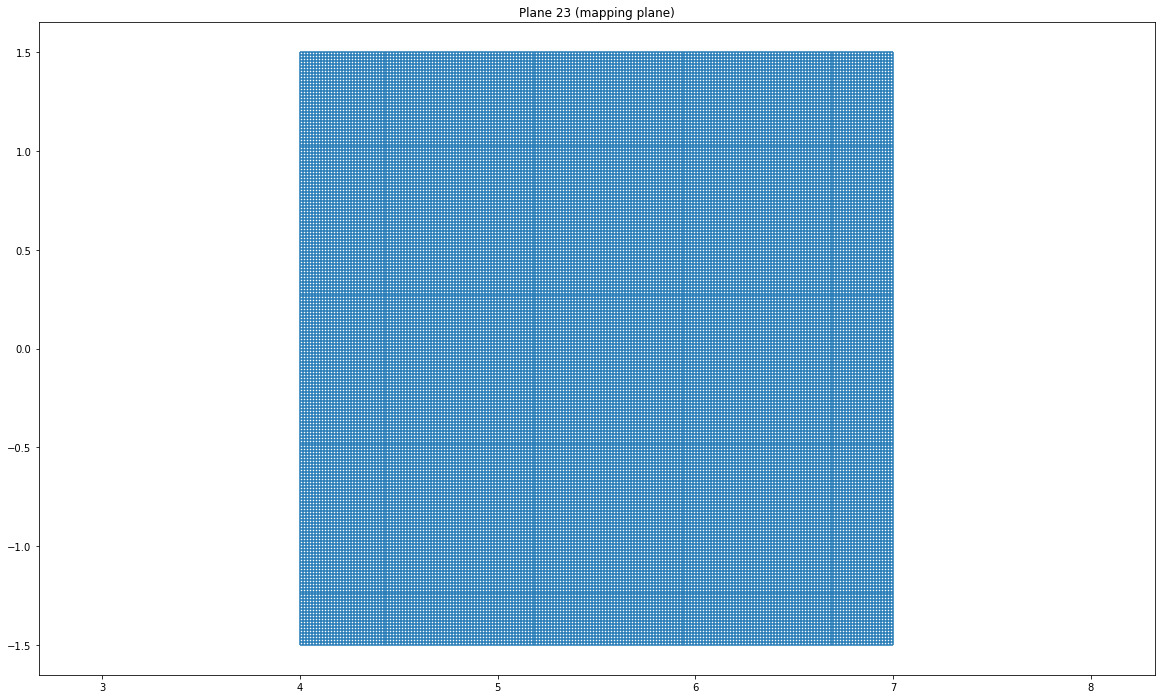

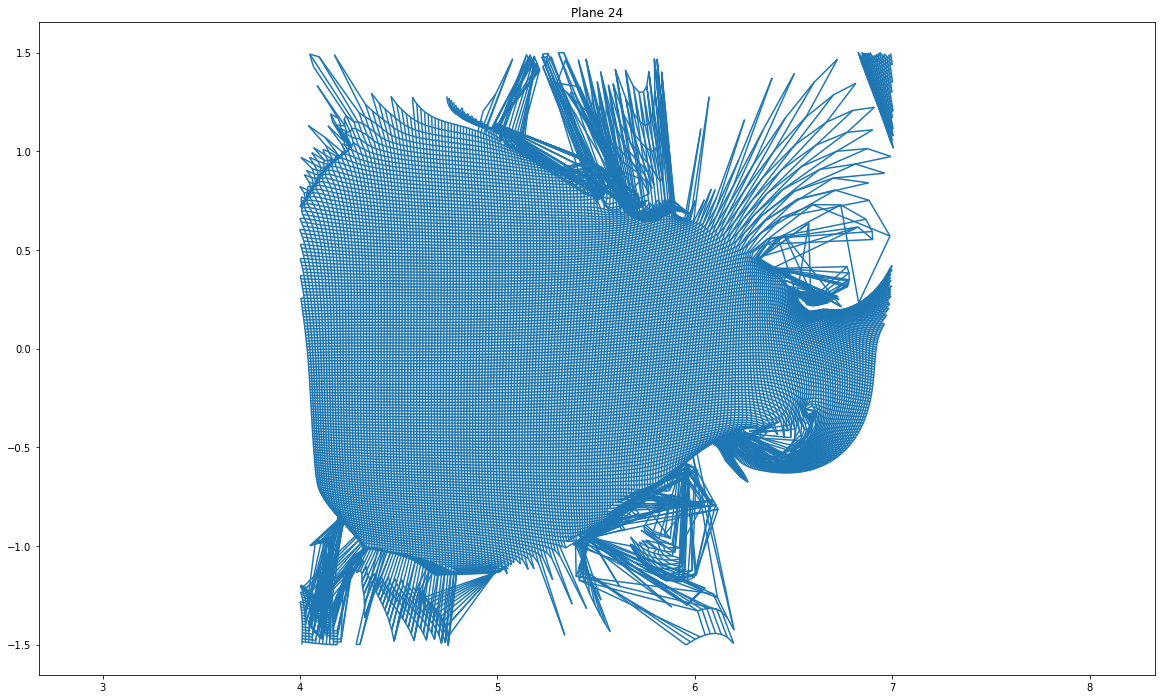

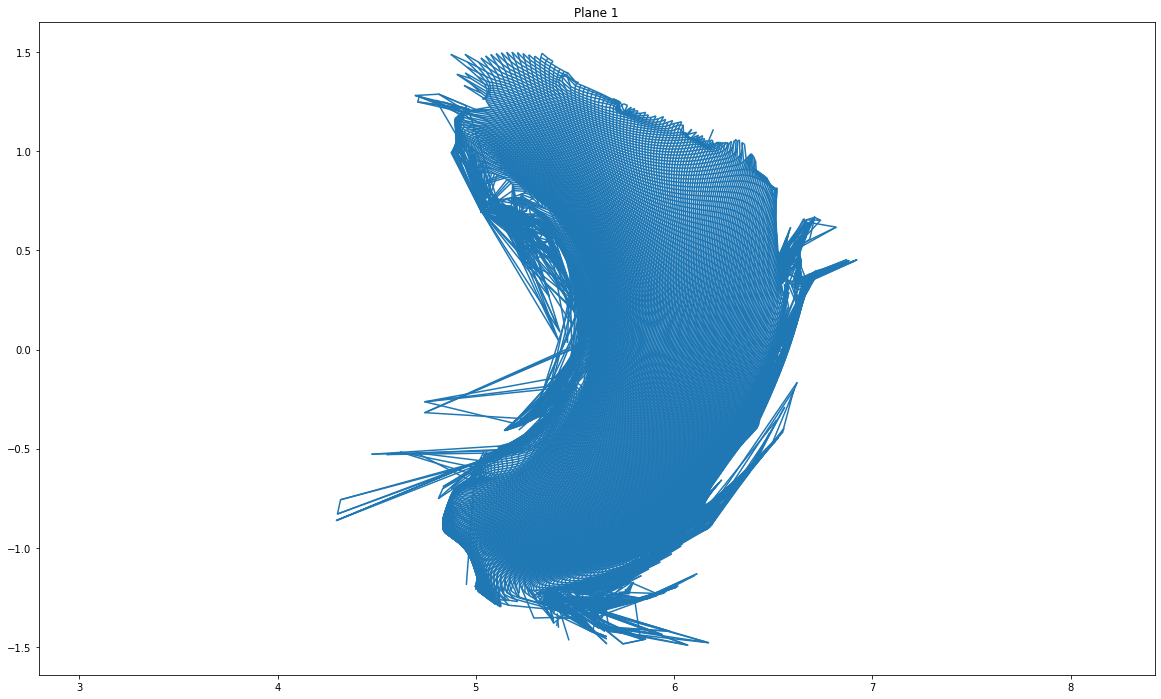

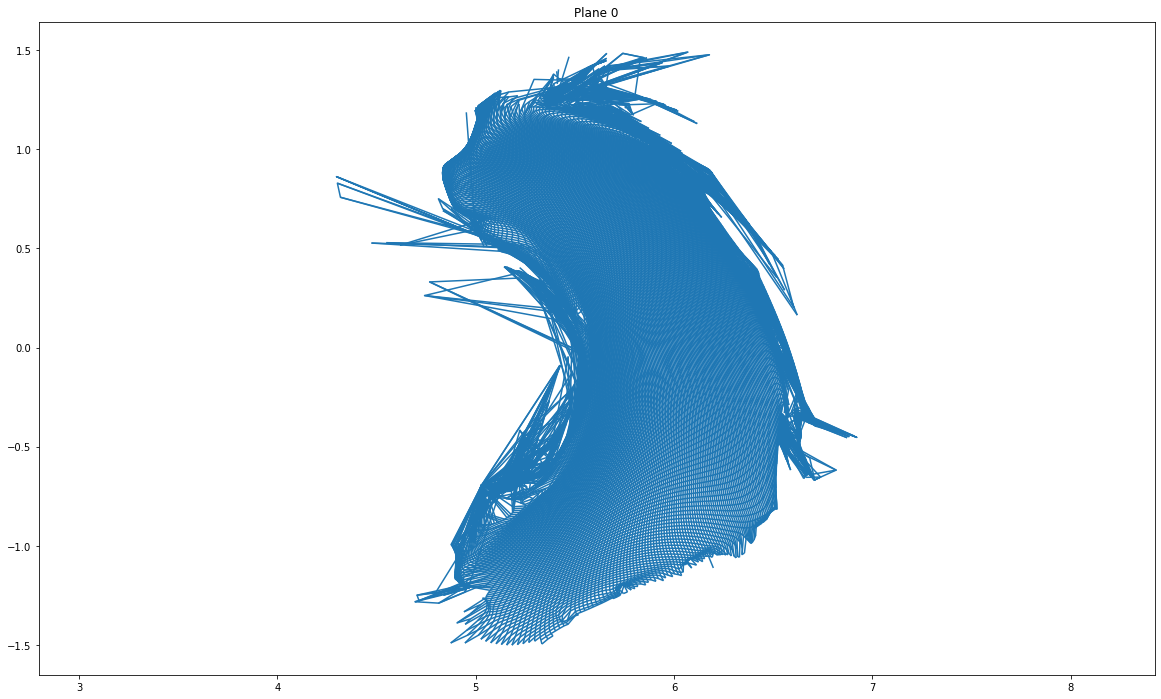

In [8]:
section1 = data.sections[0]

r = np.asarray(section1.r)
z = np.asarray(section1.z)

def plot_grid(x,y, ax=None, **kwargs):
    from matplotlib.collections import LineCollection
    
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

for i in [(len(r) - 1) // 2, (len(r) - 1) // 2 + 1, 0, -1]:
    plt.figure(figsize = (20, 12))
    plot_grid(r[i], z[i])
    plt.axis('equal')
    if i == (len(r) - 1) // 2:
        plt.title("Plane {} (mapping plane)".format(i+1))
    else:
        plt.title("Plane {}".format(i + 1))
    plt.show()

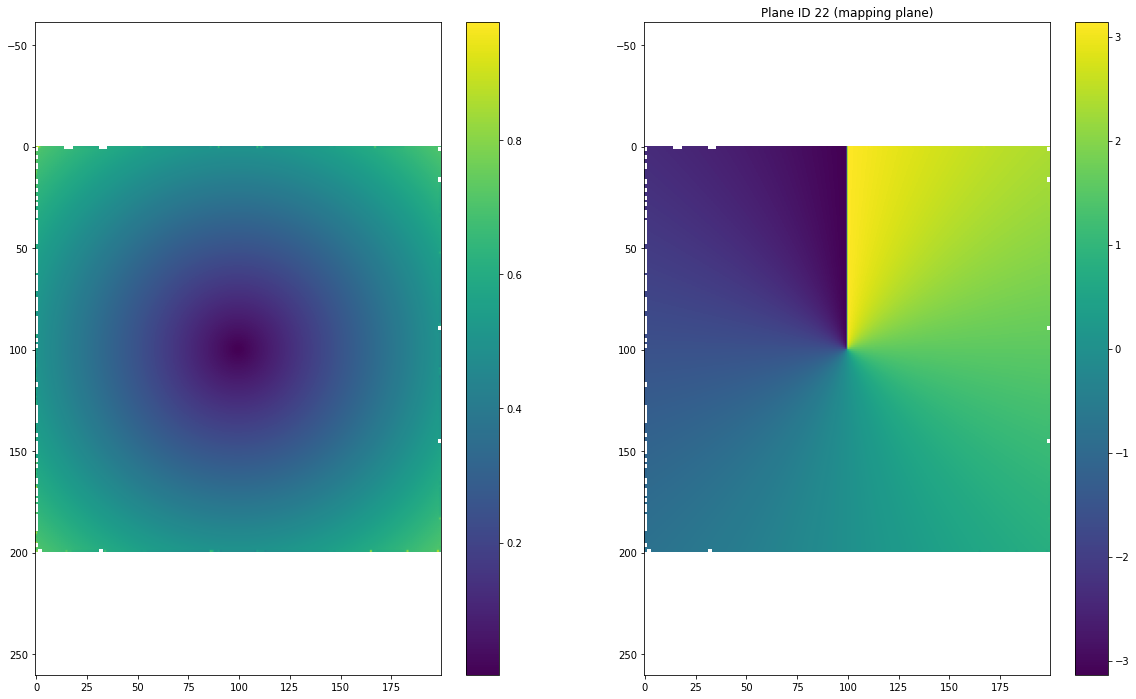

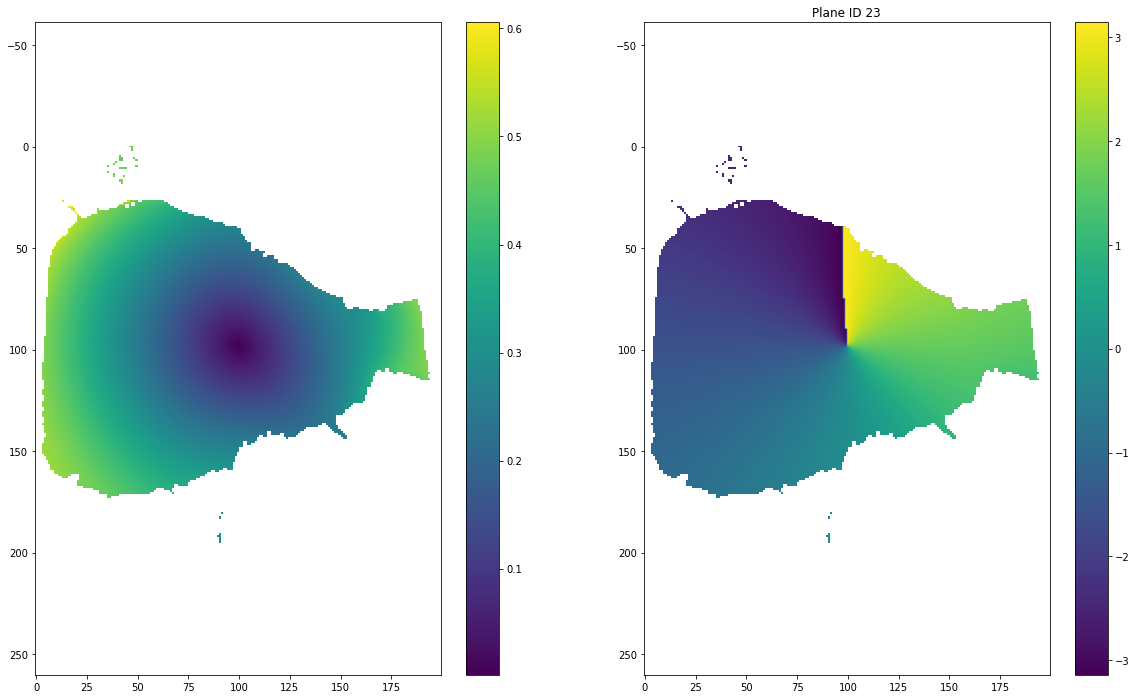

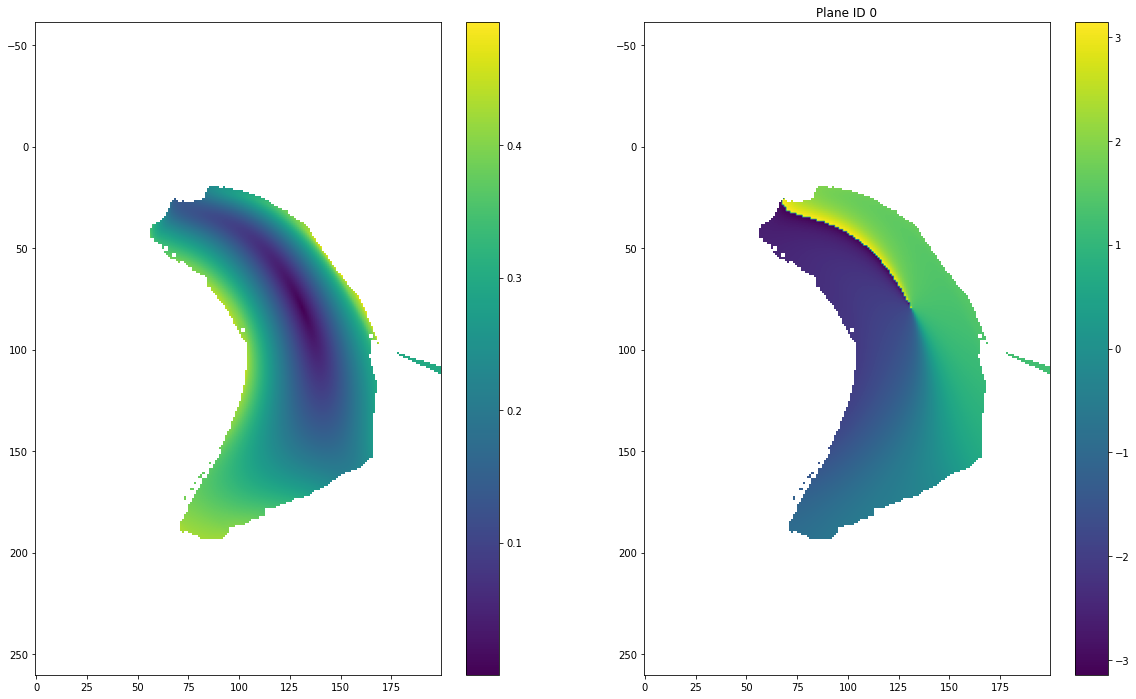

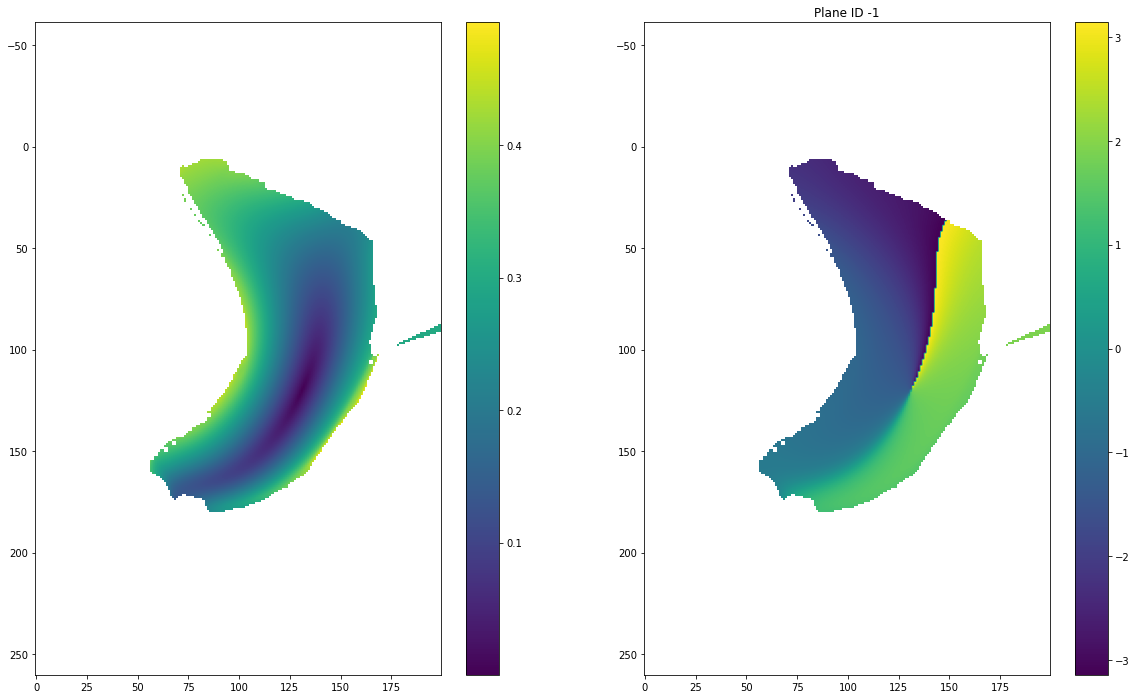

In [8]:
section1 = data.sections[0]

u = np.asarray(section1.inverse.u) - 0.5
v = np.asarray(section1.inverse.v) - 0.5

r = np.sqrt(u**2 + v**2)
theta = np.arctan2(u, v)

for i in [(len(r) - 1) // 2, (len(r) - 1) // 2 + 1, 0, -1]:
    plt.figure(figsize = (20, 12))
    plt.subplot(121)
    plt.imshow(r[i])
    plt.colorbar()
    plt.axis('equal')
    
    plt.subplot(122)
    plt.imshow(theta[i])
    plt.colorbar()
    plt.axis('equal')
    
    if i == (len(r) - 1) // 2:
        plt.title("Plane ID {} (mapping plane)".format(i))
    else:
        plt.title("Plane ID {}".format(i))
    plt.show()

## Employing the mapping to accelerate computations

### Poincare maps with high turn counts

In [8]:
rStart = np.linspace(4.4, 4.5, 2)
phi = np.radians(72 * 0 + 36)
xStart = np.cos(phi) * rStart
yStart = np.sin(phi) * rStart
zStart = 0 * rStart

pStart = [xStart, yStart, zStart]
#xStart = np.linspace([5.5, 0, 0], [5.8, 0, 0], 40, axis = 1)

pc = fsc.flt.poincareInPhiPlanes(pStart, field, [0, np.pi, np.radians(200.8)], 2000, distanceLimit = 1e7, stepSize = 0.25, mapping = mapping, geometry = geometry)

In [11]:
fsc.flt.trace(pStart, field, turnLimit = 10, stepSize = 0.25, mapping = mapping)

{'endPoints': array([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]]),
 'poincareHits': array([], shape=(5, 0, 2, 1), dtype=float64),
 'stopReasons': array([nanEncountered, nanEncountered], dtype=object),
 'fieldLines': array([], shape=(3, 2, 0), dtype=float64),
 'fieldStrengths': array([], shape=(2, 0), dtype=float64),
 'endTags': {},
 'numSteps': array([1, 1], dtype=uint64),
 'responseSize': 432}

In [12]:
# Let's count the number of Poincare points
np.isfinite(pc[0]).sum()

6

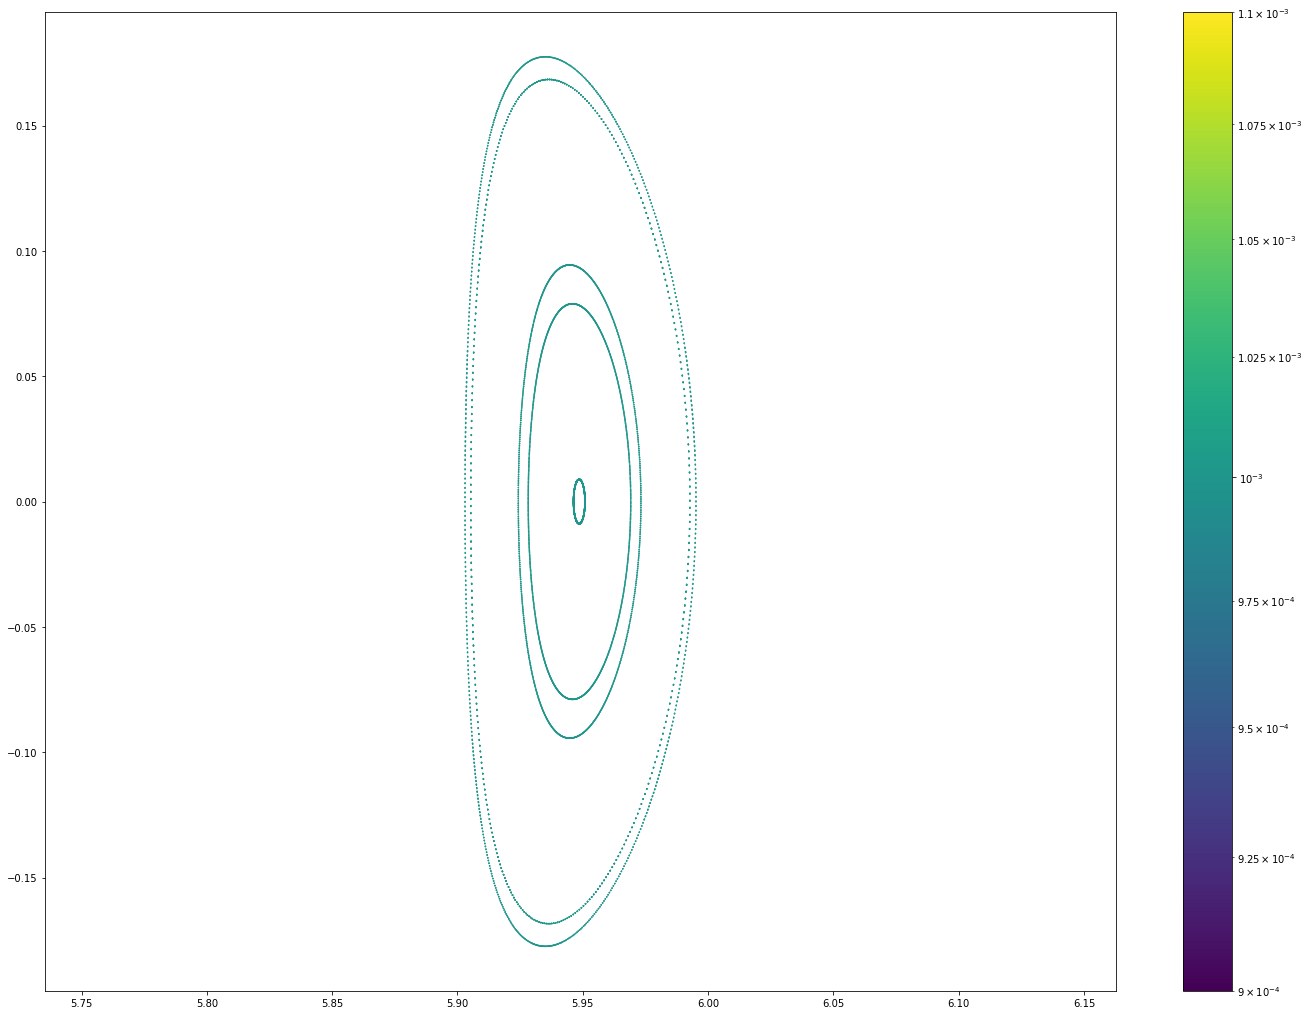

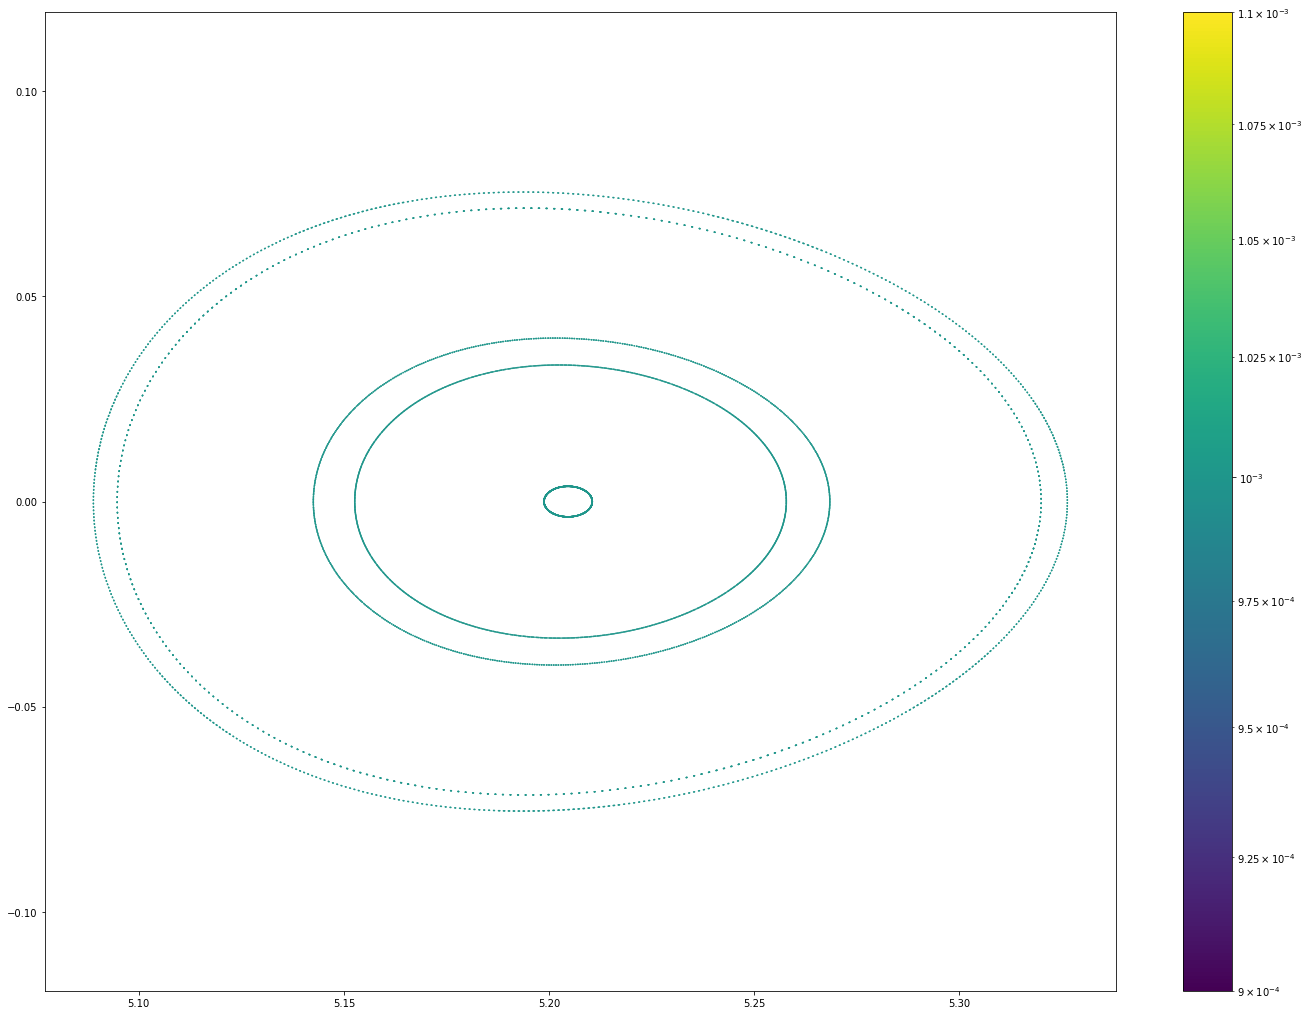

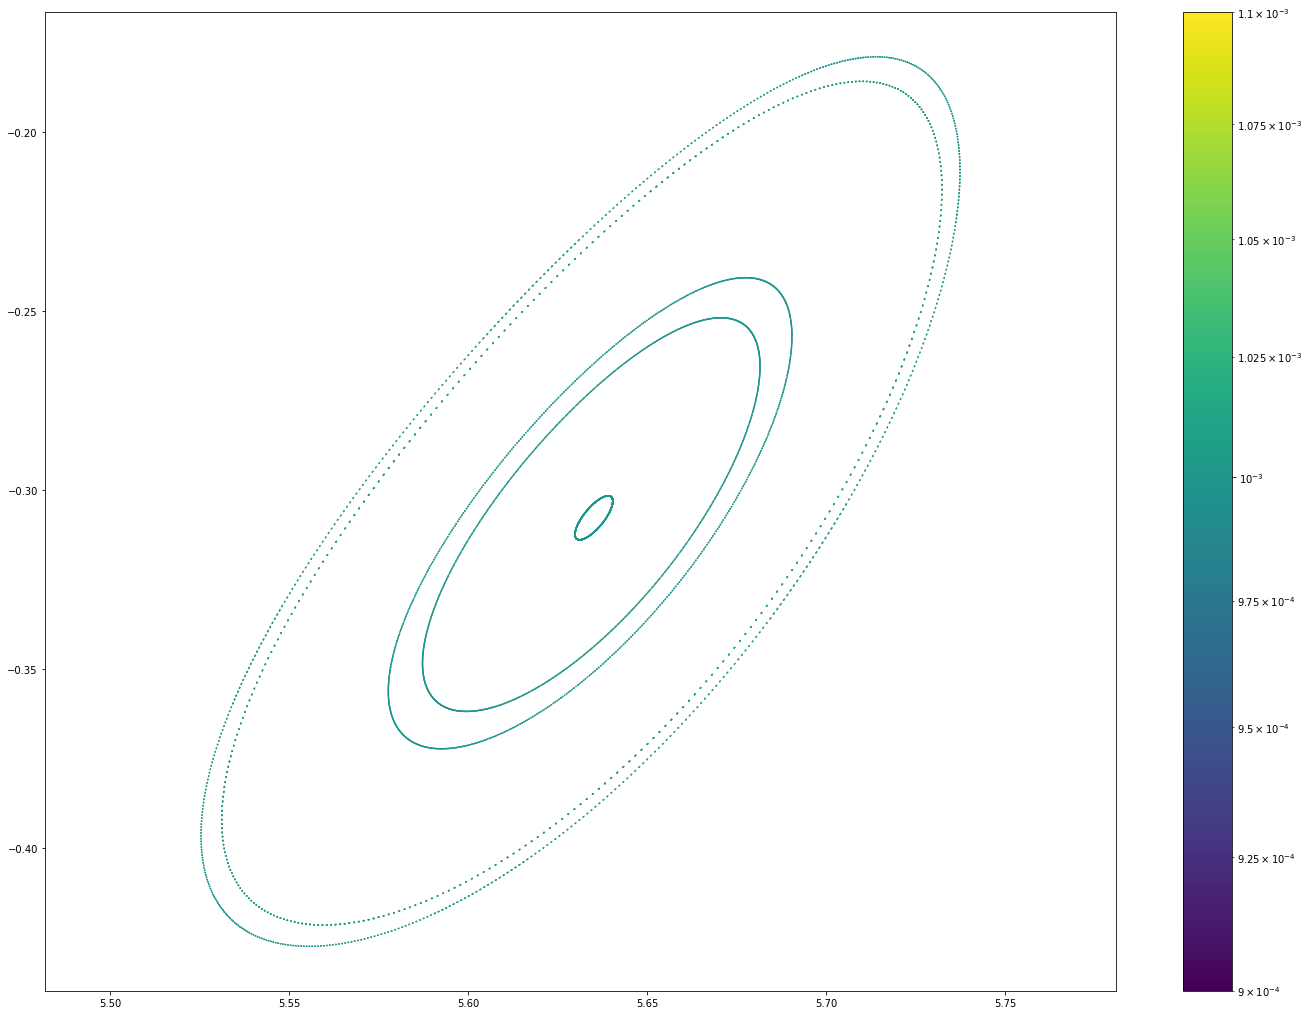

In [15]:
from matplotlib.colors import LogNorm

x, y, z, lF, lB = pc
r = np.sqrt(x**2 + y**2)

for i in range(len(x)):
    plt.figure(figsize = (24, 18))
    plt.scatter(r[i], z[i], c = np.maximum(lF + lB, 0.001)[i], marker = '.', s = 1, norm = LogNorm())
    plt.colorbar()
    plt.axis('equal')
#plt.xlim(4.5, 4.75)
#plt.ylim(-0.4, 0.4lB

### High-resolution connection length distributions

In [12]:
r = np.linspace(4.5, 4.75, 100)
z = np.linspace(-0.4, 0.4, 160)

rg, zg = np.meshgrid(r, z, indexing = 'ij')
xg = -rg
yg = 0 * rg

def calc_len(factor):
    return fsc.flt.connectionLength([xg, yg, zg], field * factor, geometry, grid = grid, mapping = mapping, distanceLimit = 1e3, stepSize = 0.1)

import time
start = time.time()
lc = calc_len(1) + calc_len(-1)
end = time.time()
print(end - start)

718.3108983039856


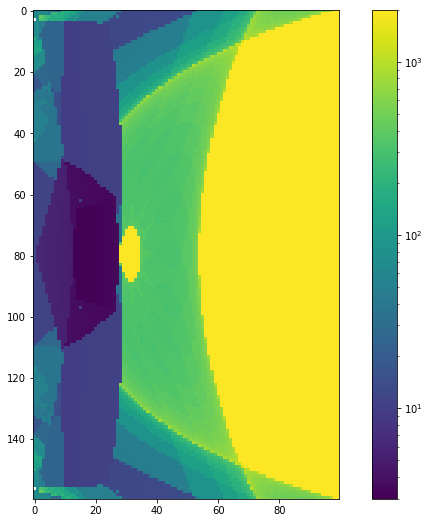

In [13]:
from matplotlib.colors import LogNorm
plt.figure(figsize = (12, 9))
plt.imshow(lc.T, norm = LogNorm())
plt.colorbar()

In [14]:
r = np.linspace(5.95, 6.1, 120)
z = np.linspace(-0.25, -0.1, 120)
phi = np.radians(200.8)

rg, zg = np.meshgrid(r, z, indexing = 'ij')
xg = np.cos(phi) * rg
yg = np.sin(phi) * rg

def calc_len(factor):
    return fsc.flt.connectionLength([xg, yg, zg], field * factor, geometry, grid = grid, mapping = mapping, distanceLimit = 1e3, stepSize = 0.1)

import time
start = time.time()
lc = calc_len(1) + calc_len(-1)
end = time.time()
print(end - start)

822.9830572605133


(5.9, 6.2, -0.4, 0.0)

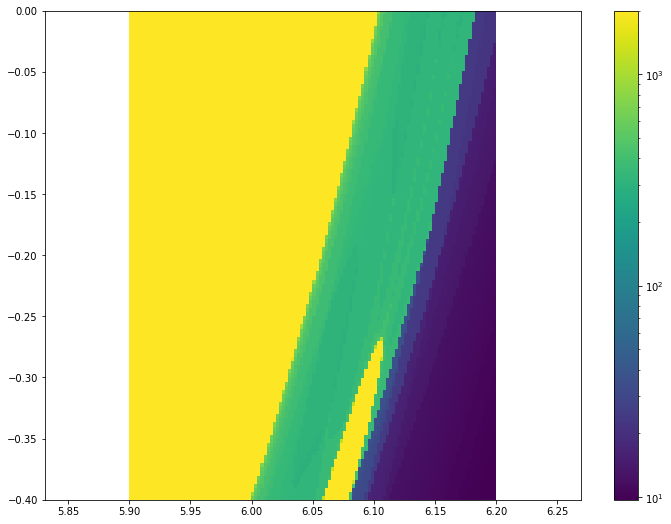

In [15]:
from matplotlib.colors import LogNorm
plt.figure(figsize = (12, 9))
plt.imshow(lc.T, norm = LogNorm(), origin = "lower", extent = [5.9, 6.2, -0.4, 0])
plt.colorbar()
plt.axis('equal')